In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import optuna

# Check scikit-learn < 1.6.0

In [21]:
df = pd.read_csv(r'datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')


['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [22]:
col1 = ['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'Overall']

# 保留在 col1 中至少有 3 个非空值的行（即缺失值 <= 4）
df = df[df[col1].notna().sum(axis=1) >= 3]
df

,Rank,Institution Name,Country,Year,CS,CF,RI,Age,STA,AR_SCORE,ER_SCORE,FS_SCORE,CPF_SCORE,IF_SCORE,IS_SCORE,IRN_SCORE,EO_SCORE,S_SCORE,Overall
0,1.0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,2018,2.0,2.0,4.0,5.0,2.0,100.0,100.0,100.0,99.9,100.0,96.1,NaN,NaN,NaN,100.0
1,2.0,STANFORD UNIVERSITY,United States,2018,3.0,3.0,4.0,5.0,2.0,100.0,100.0,100.0,99.4,99.6,72.7,NaN,NaN,NaN,98.7
2,3.0,HARVARD UNIVERSITY,United States,2018,3.0,3.0,4.0,5.0,2.0,100.0,100.0,98.3,99.9,96.5,75.2,NaN,NaN,NaN,98.4
3,4.0,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,2018,1.0,2.0,4.0,5.0,2.0,99.5,85.4,100.0,100.0,93.4,89.2,NaN,NaN,NaN,97.7
4,5.0,UNIVERSITY OF CAMBRIDGE,United Kingdom,2018,3.0,3.0,4.0,5.0,3.0,100.0,100.0,100.0,78.3,97.4,97.7,NaN,NaN,NaN,95.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10616,1401.0,University of West Bohemia,Czechia,2026,2.0,2.0,4.0,NaN,NaN,7.2,5.3,12.5,7.9,NaN,6.2,40.9,15.5,19.5,NaN
10617,1401.0,Voronezh State University,Russian Federation,2026,3.0,2.0,3.0,NaN,NaN,5.7,4.7,31.3,1.6,3.7,34.5,12.2,3.5,20.4,NaN
10618,1401.0,Walailak University,Thailand,2026,3.0,3.0,2.0,NaN,NaN,8.3,2.7,12.5,5.6,13.9,3.0,31.5,3.2,43.0,NaN
10619,1401.0,Yamaguchi University,Japan,2026,2.0,3.0,3.0,NaN,NaN,4.4,2.9,46.1,8.2,8.0,4.5,15.4,1.7,22.5,NaN


In [34]:
# select lower missing-value ratio as features(used in model)

features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

In [35]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)


0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.27% missing in Age
0.15% missing in STA
0.00% missing in AR_SCORE
0.00% missing in ER_SCORE
0.00% missing in FS_SCORE
0.00% missing in CPF_SCORE
0.11% missing in IF_SCORE
0.11% missing in IS_SCORE
37.93% missing in IRN_SCORE
37.85% missing in EO_SCORE
53.99% missing in S_SCORE
4.02% missing in Overall


In [36]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024]
print("train shape:", train_data.shape)
print("test shape:", test_data.shape)


train shape: (4113, 19)
test shape: (4994, 19)


In [37]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.8),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.8),
    }
    model = XGBRegressor(**params, random_state=2025, n_jobs=-1, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

In [38]:
best_params_dict = {}

for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=300)

    best_params = study.best_params
    best_params_dict[target] = best_params

    best_model = XGBRegressor(**best_params, random_state=2025, n_jobs=-1, verbosity=0)
    best_model.fit(X_train, y_train)

    print(f"Best parameters for {target}: {best_params}")

    X_test = test_data[features]
    test_data.loc[:, target] = best_model.predict(X_test)

[I 2025-07-19 13:59:03,074] A new study created in memory with name: no-name-b3bb41a0-8fff-42f2-bcb7-ceff99101baf
[I 2025-07-19 13:59:08,560] Trial 0 finished with value: 24.78929590370319 and parameters: {'n_estimators': 655, 'max_depth': 5, 'learning_rate': 0.10022157662394238, 'subsample': 0.5122715017267861, 'colsample_bytree': 0.7308000629305251, 'reg_alpha': 0.33866353958084733, 'reg_lambda': 0.3788168684055845}. Best is trial 0 with value: 24.78929590370319.
[I 2025-07-19 13:59:11,856] Trial 1 finished with value: 24.579958156815792 and parameters: {'n_estimators': 187, 'max_depth': 6, 'learning_rate': 0.22344460647079845, 'subsample': 0.7979702248389011, 'colsample_bytree': 0.5255346118012836, 'reg_alpha': 0.306640036250724, 'reg_lambda': 0.45146926341471894}. Best is trial 1 with value: 24.579958156815792.
[I 2025-07-19 13:59:15,771] Trial 2 finished with value: 23.77061419062636 and parameters: {'n_estimators': 584, 'max_depth': 4, 'learning_rate': 0.04747284359733649, 'subsa

Best parameters for IRN_SCORE: {'n_estimators': 374, 'max_depth': 6, 'learning_rate': 0.009765290996090685, 'subsample': 0.7756603869675217, 'colsample_bytree': 0.5957457360692652, 'reg_alpha': 0.7843915357618921, 'reg_lambda': 0.26658695143116146}


[I 2025-07-19 14:05:01,311] Trial 0 finished with value: 19.594563478764307 and parameters: {'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.006356768109604075, 'subsample': 0.6117168675928244, 'colsample_bytree': 0.5569455649793565, 'reg_alpha': 0.09213538622177345, 'reg_lambda': 0.4119077197207937}. Best is trial 0 with value: 19.594563478764307.
[I 2025-07-19 14:05:01,636] Trial 1 finished with value: 15.936961307543276 and parameters: {'n_estimators': 180, 'max_depth': 3, 'learning_rate': 0.08637653576024319, 'subsample': 0.7155501456711495, 'colsample_bytree': 0.7252586089066082, 'reg_alpha': 0.7734778754672589, 'reg_lambda': 0.6862876840552765}. Best is trial 1 with value: 15.936961307543276.
[I 2025-07-19 14:05:02,411] Trial 2 finished with value: 15.924340819063653 and parameters: {'n_estimators': 695, 'max_depth': 3, 'learning_rate': 0.019377863106892757, 'subsample': 0.7193383078500716, 'colsample_bytree': 0.7782340332441666, 'reg_alpha': 0.70731373874967, 'reg_lambda

Best parameters for EO_SCORE: {'n_estimators': 656, 'max_depth': 7, 'learning_rate': 0.04737035059852601, 'subsample': 0.7830905154562788, 'colsample_bytree': 0.7846996670048125, 'reg_alpha': 0.6875504128394073, 'reg_lambda': 0.7744508169648253}


[I 2025-07-19 14:18:41,396] Trial 0 finished with value: 18.330560646152943 and parameters: {'n_estimators': 305, 'max_depth': 7, 'learning_rate': 0.10654332754388002, 'subsample': 0.7573350122330269, 'colsample_bytree': 0.5416725030377454, 'reg_alpha': 0.41658292164108773, 'reg_lambda': 0.7508428267046333}. Best is trial 0 with value: 18.330560646152943.
[I 2025-07-19 14:18:41,729] Trial 1 finished with value: 18.900929043720385 and parameters: {'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.15119605133831737, 'subsample': 0.5546807115094341, 'colsample_bytree': 0.7400138473135388, 'reg_alpha': 0.34684243110446045, 'reg_lambda': 0.003440255506371415}. Best is trial 0 with value: 18.330560646152943.
[I 2025-07-19 14:18:42,115] Trial 2 finished with value: 19.391574272710102 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.2190875368624109, 'subsample': 0.5850079813278013, 'colsample_bytree': 0.6026297187193245, 'reg_alpha': 0.3193444085714139, 'reg_lamb

Best parameters for S_SCORE: {'n_estimators': 660, 'max_depth': 7, 'learning_rate': 0.044024063251383305, 'subsample': 0.6549041657274367, 'colsample_bytree': 0.7798542085896776, 'reg_alpha': 0.6425964213204216, 'reg_lambda': 0.5147806164924884}


[I 2025-07-18 13:17:14,685] Trial 0 finished with value: 15.209181473313015 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.13824053384251103, 'subsample': 0.6047270743625458, 'colsample_bytree': 0.7951148014578113, 'reg_alpha': 0.7949870574933016, 'reg_lambda': 0.12129132908384266}. Best is trial 0 with value: 15.209181473313015.
[I 2025-07-18 13:17:14,956] Trial 1 finished with value: 15.353266690626782 and parameters: {'n_estimators': 537, 'max_depth': 4, 'learning_rate': 0.028990947906970457, 'subsample': 0.7888316782991692, 'colsample_bytree': 0.7898961092788688, 'reg_alpha': 0.7097470102757469, 'reg_lambda': 0.189741031239278}. Best is trial 0 with value: 15.209181473313015.
[I 2025-07-18 13:17:15,210] Trial 2 finished with value: 16.419542179960185 and parameters: {'n_estimators': 397, 'max_depth': 5, 'learning_rate': 0.2504486991060051, 'subsample': 0.5401277706339471, 'colsample_bytree': 0.5278844872198104, 'reg_alpha': 0.10534686961770952, 'reg_lambda

[I 2025-07-18 13:17:25,009] Trial 23 finished with value: 14.875406386297167 and parameters: {'n_estimators': 561, 'max_depth': 6, 'learning_rate': 0.13115141041323766, 'subsample': 0.7611990714838203, 'colsample_bytree': 0.7620534077956507, 'reg_alpha': 0.7298222639177399, 'reg_lambda': 0.3960291296771525}. Best is trial 21 with value: 14.677154162971261.
[I 2025-07-18 13:17:25,336] Trial 24 finished with value: 14.755927021676149 and parameters: {'n_estimators': 337, 'max_depth': 6, 'learning_rate': 0.0792540791124406, 'subsample': 0.694538830938426, 'colsample_bytree': 0.6635588514926175, 'reg_alpha': 0.5865272098202838, 'reg_lambda': 0.49233574073907305}. Best is trial 21 with value: 14.677154162971261.
[I 2025-07-18 13:17:25,756] Trial 25 finished with value: 14.884478007559286 and parameters: {'n_estimators': 623, 'max_depth': 5, 'learning_rate': 0.040579559669758965, 'subsample': 0.6523470476652221, 'colsample_bytree': 0.7113931682519972, 'reg_alpha': 0.4346584567907047, 'reg_la

[I 2025-07-18 13:17:38,170] Trial 46 finished with value: 14.691635337330746 and parameters: {'n_estimators': 462, 'max_depth': 7, 'learning_rate': 0.1127399984477298, 'subsample': 0.7066377098741922, 'colsample_bytree': 0.6238513185270287, 'reg_alpha': 0.7040382781795068, 'reg_lambda': 0.7992218118695988}. Best is trial 36 with value: 14.546523963000922.
[I 2025-07-18 13:17:38,961] Trial 47 finished with value: 15.374476506076206 and parameters: {'n_estimators': 646, 'max_depth': 7, 'learning_rate': 0.2127600127227342, 'subsample': 0.7995920145979234, 'colsample_bytree': 0.5823849944602777, 'reg_alpha': 0.5597848296876677, 'reg_lambda': 0.6164346292574345}. Best is trial 36 with value: 14.546523963000922.
[I 2025-07-18 13:17:39,765] Trial 48 finished with value: 14.573974681038699 and parameters: {'n_estimators': 608, 'max_depth': 7, 'learning_rate': 0.03630596962294746, 'subsample': 0.769389074012844, 'colsample_bytree': 0.6503285868274425, 'reg_alpha': 0.1593097656897795, 'reg_lambd

[I 2025-07-18 13:17:53,682] Trial 69 finished with value: 14.66002475343852 and parameters: {'n_estimators': 666, 'max_depth': 6, 'learning_rate': 0.02478769722413926, 'subsample': 0.7069048623720565, 'colsample_bytree': 0.7651374995782256, 'reg_alpha': 0.23816162687100073, 'reg_lambda': 0.1598262943660961}. Best is trial 58 with value: 14.520658404677997.
[I 2025-07-18 13:17:54,672] Trial 70 finished with value: 14.540339466357437 and parameters: {'n_estimators': 659, 'max_depth': 7, 'learning_rate': 0.019813871378030597, 'subsample': 0.7765652034034832, 'colsample_bytree': 0.7410021860487288, 'reg_alpha': 0.42317684908135583, 'reg_lambda': 0.31903375890037816}. Best is trial 58 with value: 14.520658404677997.
[I 2025-07-18 13:17:55,616] Trial 71 finished with value: 14.512742924952269 and parameters: {'n_estimators': 657, 'max_depth': 7, 'learning_rate': 0.023242183040604884, 'subsample': 0.7787527671300848, 'colsample_bytree': 0.749589971386291, 'reg_alpha': 0.3447237122280309, 'reg

[I 2025-07-18 13:18:15,491] Trial 92 finished with value: 14.671697555946402 and parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.05420976567036194, 'subsample': 0.6057494103438648, 'colsample_bytree': 0.7744572864868382, 'reg_alpha': 0.5467794875413516, 'reg_lambda': 0.20418344791129506}. Best is trial 85 with value: 14.433261701837077.
[I 2025-07-18 13:18:16,473] Trial 93 finished with value: 14.451188463449961 and parameters: {'n_estimators': 675, 'max_depth': 7, 'learning_rate': 0.033001446959159214, 'subsample': 0.6258356319227678, 'colsample_bytree': 0.7298568415898413, 'reg_alpha': 0.4851519243067773, 'reg_lambda': 0.18713832460021615}. Best is trial 85 with value: 14.433261701837077.
[I 2025-07-18 13:18:17,455] Trial 94 finished with value: 14.447093300389454 and parameters: {'n_estimators': 686, 'max_depth': 7, 'learning_rate': 0.0328212442846281, 'subsample': 0.628443871518661, 'colsample_bytree': 0.7264096486019496, 'reg_alpha': 0.4892816447565292, 'reg_l

Best parameters for EO_SCORE: {'n_estimators': 691, 'max_depth': 7, 'learning_rate': 0.04236457819589092, 'subsample': 0.577549687319652, 'colsample_bytree': 0.7591123791757265, 'reg_alpha': 0.531923418210322, 'reg_lambda': 0.24190320465294105}


[I 2025-07-18 13:18:23,284] Trial 0 finished with value: 19.03639594935159 and parameters: {'n_estimators': 481, 'max_depth': 3, 'learning_rate': 0.11755988846635429, 'subsample': 0.6453386085479849, 'colsample_bytree': 0.5896720725435152, 'reg_alpha': 0.15335203068518757, 'reg_lambda': 0.15066707409107638}. Best is trial 0 with value: 19.03639594935159.
[I 2025-07-18 13:18:23,407] Trial 1 finished with value: 19.308447262265627 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2624518064492319, 'subsample': 0.6601130105358888, 'colsample_bytree': 0.7566100579640247, 'reg_alpha': 0.07943397505878665, 'reg_lambda': 0.1757190362450155}. Best is trial 0 with value: 19.03639594935159.
[I 2025-07-18 13:18:23,878] Trial 2 finished with value: 19.63257667724704 and parameters: {'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.24003773977419118, 'subsample': 0.5021473354807361, 'colsample_bytree': 0.5974653655231902, 'reg_alpha': 0.506961350264443, 'reg_lambda': 0

[I 2025-07-18 13:18:29,687] Trial 23 finished with value: 18.59632883786174 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.05007723376250602, 'subsample': 0.5236898401459209, 'colsample_bytree': 0.6144918792490258, 'reg_alpha': 0.46473425542412017, 'reg_lambda': 0.05382337261635567}. Best is trial 16 with value: 18.553241074384104.
[I 2025-07-18 13:18:30,023] Trial 24 finished with value: 18.43369696382706 and parameters: {'n_estimators': 230, 'max_depth': 7, 'learning_rate': 0.06314578226994519, 'subsample': 0.5587994761113517, 'colsample_bytree': 0.6284249086415231, 'reg_alpha': 0.4817090107722889, 'reg_lambda': 0.020621973112371683}. Best is trial 24 with value: 18.43369696382706.
[I 2025-07-18 13:18:30,344] Trial 25 finished with value: 18.98118606007939 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.1533995631808362, 'subsample': 0.5598091539150433, 'colsample_bytree': 0.5623138234253379, 'reg_alpha': 0.6898061422985388, 'reg_lam

[I 2025-07-18 13:18:43,391] Trial 46 finished with value: 19.20857148281645 and parameters: {'n_estimators': 608, 'max_depth': 7, 'learning_rate': 0.209259614337892, 'subsample': 0.5985088817819816, 'colsample_bytree': 0.647090759734903, 'reg_alpha': 0.7916549212354157, 'reg_lambda': 0.15354638526701114}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:44,078] Trial 47 finished with value: 18.11996653006082 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.06416646497616679, 'subsample': 0.7164838115061141, 'colsample_bytree': 0.6633460872457593, 'reg_alpha': 0.695184172783942, 'reg_lambda': 0.11105082303743923}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:44,714] Trial 48 finished with value: 18.294427795173352 and parameters: {'n_estimators': 691, 'max_depth': 6, 'learning_rate': 0.0604220738727688, 'subsample': 0.7193052396478081, 'colsample_bytree': 0.6618840823561899, 'reg_alpha': 0.6983969547994356, 'reg_lambda'

[I 2025-07-18 13:18:56,330] Trial 69 finished with value: 18.116569437687907 and parameters: {'n_estimators': 337, 'max_depth': 7, 'learning_rate': 0.03327418944531765, 'subsample': 0.7762818988603165, 'colsample_bytree': 0.7448725205341171, 'reg_alpha': 0.22298078929551926, 'reg_lambda': 0.6661209562011192}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:56,814] Trial 70 finished with value: 18.124203260815456 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.04639678959585765, 'subsample': 0.7763975014766682, 'colsample_bytree': 0.7385158525254306, 'reg_alpha': 0.01458041077665348, 'reg_lambda': 0.6570569630236132}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:57,323] Trial 71 finished with value: 18.13067089358363 and parameters: {'n_estimators': 313, 'max_depth': 7, 'learning_rate': 0.04562131827933862, 'subsample': 0.7800690840706859, 'colsample_bytree': 0.739480237313247, 'reg_alpha': 0.12514787815794592, 'reg_l

[I 2025-07-18 13:19:10,056] Trial 92 finished with value: 17.973751958462824 and parameters: {'n_estimators': 380, 'max_depth': 7, 'learning_rate': 0.034584086624606276, 'subsample': 0.7282285810189297, 'colsample_bytree': 0.7640011276778356, 'reg_alpha': 0.08303706653908527, 'reg_lambda': 0.5667702393467992}. Best is trial 90 with value: 17.953888828723702.
[I 2025-07-18 13:19:10,510] Trial 93 finished with value: 17.99740093364807 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.038178774046069786, 'subsample': 0.7303745285031916, 'colsample_bytree': 0.7688671250173061, 'reg_alpha': 0.08560344741233115, 'reg_lambda': 0.558495066202786}. Best is trial 90 with value: 17.953888828723702.
[I 2025-07-18 13:19:11,116] Trial 94 finished with value: 17.96697258989683 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.03799333168388957, 'subsample': 0.7276379387471169, 'colsample_bytree': 0.7684524514257787, 'reg_alpha': 0.0836647435971658, 'reg_l

Best parameters for S_SCORE: {'n_estimators': 403, 'max_depth': 7, 'learning_rate': 0.04734613782132609, 'subsample': 0.7082159140096435, 'colsample_bytree': 0.7841739531122089, 'reg_alpha': 0.11136290616214914, 'reg_lambda': 0.5331132898956379}


In [39]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS_XGB.csv', index=False)

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\zxy\AppData\Local\Temp\ipykernel_5276\2983516680.py:3: SyntaxWarning: invalid escape sequence '\i'
  combined_data.to_csv('datasets\imputed_data_QS_XGB.csv', index=False)


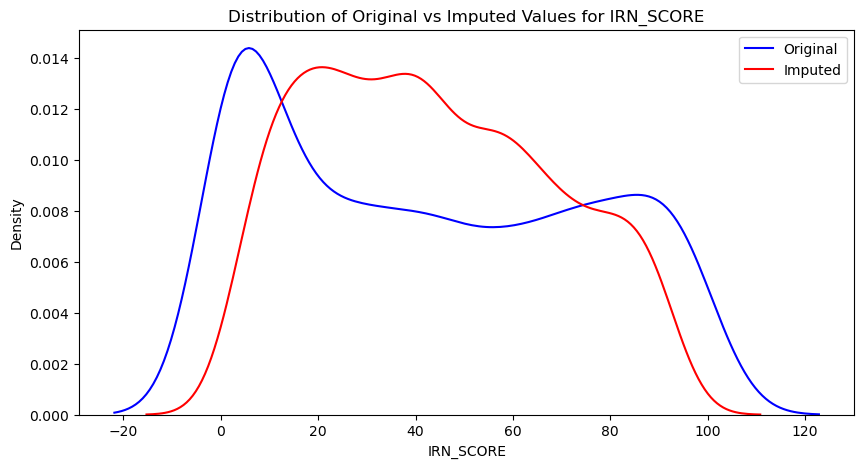

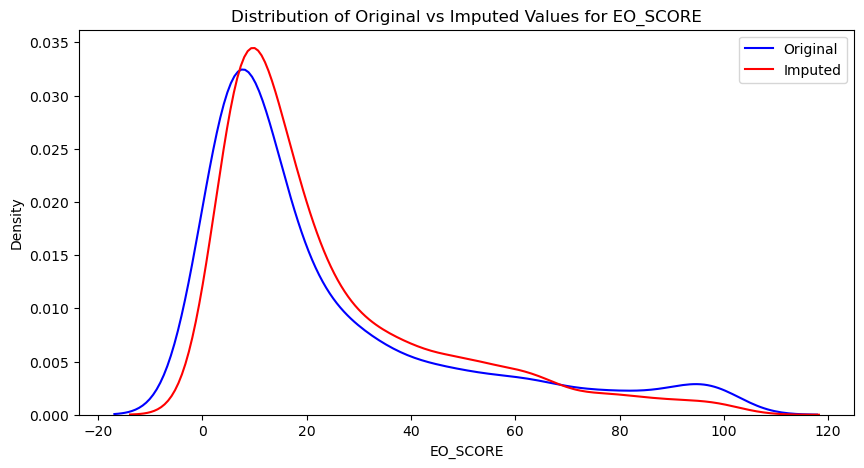

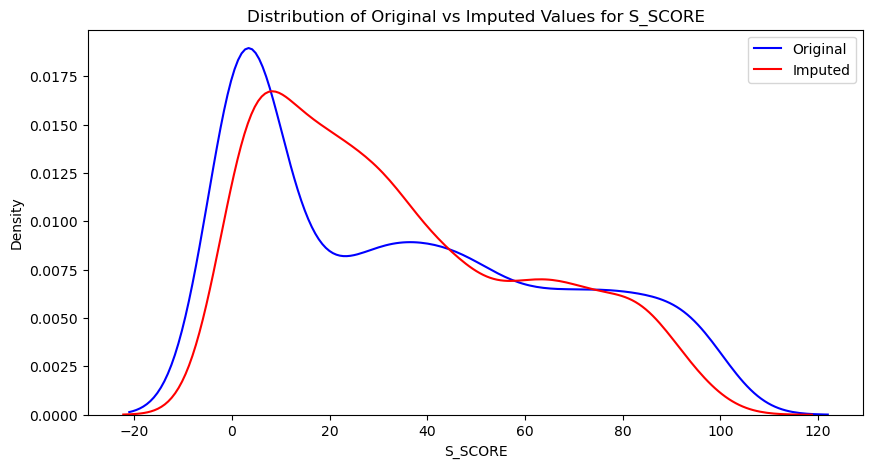

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.672515  18.638668  14.725132
1   EO_SCORE  0.676908  14.478219   9.540230
2    S_SCORE  0.749432  15.704017  11.796046


In [41]:
synthetic_data = train_data.copy().dropna()
for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.35 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# 评估部分
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]

    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]

    best_params = best_params_dict[target]
    model = XGBRegressor(**best_params, random_state=2025, n_jobs=-1, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)

    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()
    
metrics_df = pd.DataFrame(metrics)
print(metrics_df)